# Result processing for master thesis

We want to test 2 things:

- Q1: Can we predict the flipping of a condition:
Can we predict based on a set of metrics IF we will flip a branch (classification in flip or no flip)

- Q2: Is there a strategy which performs better than other strategies:
Can we predict based on a set of metrics WHICH strategy we can use to optimize the time spend on the branch. (classification on strategy with time metric to optimize)

## Importing data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

STRATEGIES = ['GradientDescentStrategy', 'MagicByteStrategy' , 'OneByteStrategy', 'LengthTaintStrategy', 'ConcolicStrategy', 'RandomStrategy', 'RandomTaintStrategy']
VARIABLES_TO_TEST = ['oviedo', 'cyclomatic' , 'nrOfOffsets', 'cases', 'chain_size', 'depth2', 'trace_length']
PROGRAMS = [#"gif2png", 
"file", "nm", "djpeg", "jhead", #"xmlwf",
]

all_data = []
for program in PROGRAMS:
    print("Reading " + "../results/%s_raw_depth.csv" % program)
    program_data = pd.read_csv("../results/%s_raw_depth.csv" % program, index_col=False)
    program_data["program"] = program
    all_data.append(program_data)
data = pd.concat(all_data)
#set right types
data["program"] = data["program"].astype('category')
data["status"] = data["status"].astype('category')
data["Strategy"] = data["Strategy"].astype('category')

#add new column
data["relative_depth"] = data["depth2"]/data["trace_length"]


Reading ../results/file_raw_depth.csv
Reading ../results/nm_raw_depth.csv
Reading ../results/djpeg_raw_depth.csv
Reading ../results/jhead_raw_depth.csv


In [21]:
data.groupby(["program"]).describe()

cmpid                                                         \
            count          mean           std          min           25%   
program                                                                    
djpeg      3577.0  2.166134e+09  7.874457e+08  611337383.0  1.903821e+09   
file      32095.0  2.500750e+09  1.229003e+09   38470707.0  1.423255e+09   
jhead      7343.0  3.154597e+09  6.339629e+08  610160718.0  3.307622e+09   
nm       140091.0  1.737491e+09  7.747063e+08   63528831.0  1.452850e+09   

                                                  nrOfMisses              ...  \
                  50%           75%           max      count        mean  ...   
program                                                                   ...   
djpeg    1.903842e+09  1.903878e+09  4.249747e+09     3577.0   36.618116  ...   
file     2.957917e+09  3.491171e+09  4.269747e+09    32095.0  148.190902  ...   
jhead    3.307644e+09  3.307668e+09  4.243289e+09     7343.0  152.871034  ...   
nm       1.693393e+09  2.355263e+09  4.223215e+09   140091.0  191.395314  ...   

        flipped      relative_depth                                     \
            75%  max          count      mean       std  min       25%   
program                                                                  
djpeg       0.0  1.0         3577.0  0.848772  0.147670  0.0  0.740196   
file        0.0  1.0        32095.0  0.540461  0.319945  0.0  0.259773   
jhead       0.0  1.0         7343.0  0.550608  0.274634  0.0  0.327062   
nm          0.0  1.0       140091.0  0.699881  0.233462  0.0  0.512786   

                                       
              50%       75%       max  
program                                
djpeg    0.916084  0.958333  0.995434  
file     0.522380  0.845361  0.999596  
jhead    0.538217  0.842105  0.995961  
nm       0.731288  0.919448  0.999743  

[4 rows x 80 columns]

## Inspect data

We will look at the number of flips per strategy per binary

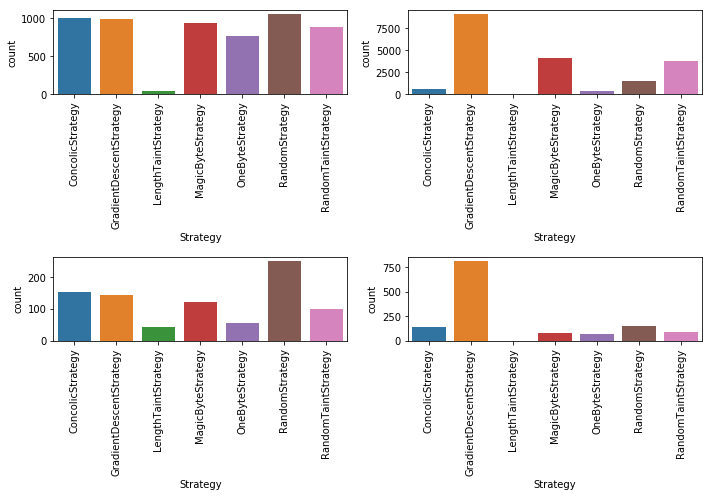

In [49]:

df = data
programs = df.program.unique()
fig, axs = plt.subplots(nrows=int(programs.size/2), ncols=2, figsize =(10, df["Strategy"].unique().size))
axs = axs.flatten()
for ax, program in zip(axs,programs):
    ax = sns.countplot(x="Strategy", data=df[ (df["program"] == program) & (df["flipped"] == 1)], order=df.Strategy.cat.categories,  ax=ax)
    ax.set_xticklabels(df.Strategy.cat.categories, rotation = 90)
plt.tight_layout()

### Correlation
We will filter the values of - from the data and see the correlation coefficient between the metrics

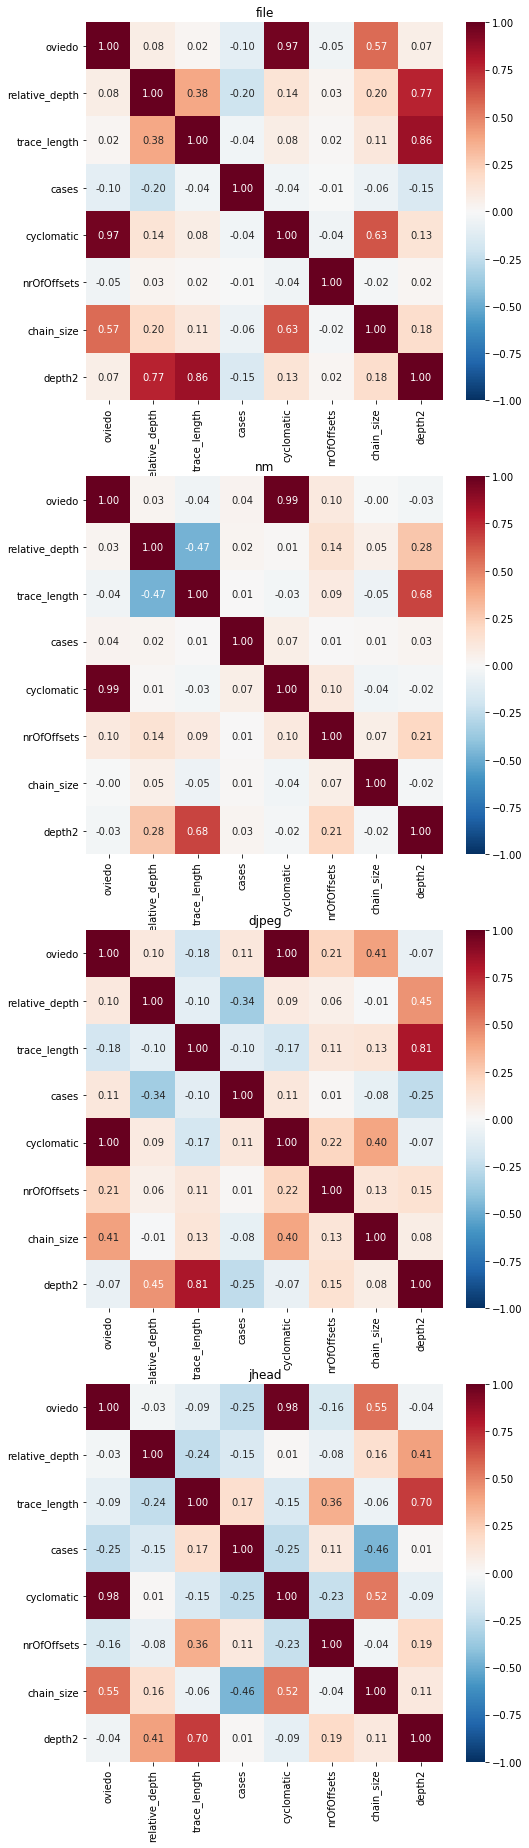

In [53]:
columns = set(['relative_depth', 'program'])
columns.update(set(VARIABLES_TO_TEST))
df_copy = df[columns].copy()
for column in columns:
    df_copy = df_copy[df_copy[column] != '-']
programs = df_copy.program.unique()
for variable in VARIABLES_TO_TEST:
    df_copy[variable] = df_copy[variable].astype('float')
fig, axs = plt.subplots(nrows=programs.size, figsize=(8, programs.size * 8))
for ax, f in zip(axs, df_copy.program.unique()):
    ax.set_title(f)
    ax = sns.heatmap(df_copy[df_copy.program == f].corr(),
                    fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1)
fig.savefig("output.png", dpi=300)